# Auto-Encoding Variational Bayes

This notebook intends to reproduce the work of [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114), which bridges the variational inference and auto-encoder theory, and proposes a general efficient learning algorithm on directed probabilistic modelling with latent varaiables.

Our work includes:
- implements the variational auto encoder model for MNIST dataset, consist of:
    - the gaussian MLP encoder, modelling the posterior prob, $q_{\phi}(z|x)$
    - the bernoulli MLP decoder, modelling the generative process, $p_{\theta}(x|z)$
- conduct experiment to study the role of the dimensionality of latent space
- show the learned manifold for the generative model on MNIST

In [1]:
from paperlab.zoo import vae
from paperlab.core import Config, ExpRunner

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Dimensionality of latent space
We will study how the dimensionality of latent space affects the performance of VAE model, in terms of optimizing the evidence lower bound.

Based on the studies of auto-encoders, higer dimensionality means larger bottlneck of encoder and more free parameters in the model, thus leads to better fitting performace but also higher risk of overfitting. Let's see if it goes as expected.

In [2]:
# process the experiment results
def process_exp_results(exp_results):
    train_stats, test_stats = [], []
    for result in exp_results:
        train_elbos, test_elbos = result

        train_stats.append(train_elbos)
        test_stats.append(test_elbos)
    
    return pd.DataFrame(train_stats).mean(), pd.DataFrame(test_stats).mean()

In [ ]:
basic_params = {
    'model.dim_latent': 2,
    'model.dim_input': 28 * 28,
    'model.dim_hidden': 500,
    'learning.batch_size': 100,
    'learning.lr': 0.02,
    'learning.num_epoch': 500,
}
config = Config(**basic_params)

# change latent space from 3 to 200
stats = {}
for dim_latent in [3, 5, 10, 20, 200]:
    config.model.dim_latent = dim_latent
    # setup the experiment runner, you're encouraged to check source code defined in `vae.exp`
    runner = ExpRunner(exp_func=vae.exp, exp_config={'config': config}, repeat_num=5)
    # run experiment using multi-processing speed up
    runner.run_mp()
    train_elbo_cruve, test_elbo_cruve = process_exp_results(runner.exp_results)
    stats[dim_latent] = train_elbo_cruve, test_elbo_cruve

experiment starts ...
repeat running 5 times, random seeds are [0, 1, 2, 3, 4]
config:
	 config = {'model': {'dim_latent': 3, 'dim_input': 784, 'dim_hidden': 500}, 'learning': {'batch_size': 100, 'lr': 0.02, 'num_epoch': 500}}
Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.
Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.


Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.
Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.


Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is 

  0%|          | 0/5 [00:00<?, ?it/s]

experiment starts ...
repeat running 5 times, random seeds are [0, 1, 2, 3, 4]
config:
	 config = {'model': {'dim_latent': 5, 'dim_input': 784, 'dim_hidden': 500}, 'learning': {'batch_size': 100, 'lr': 0.02, 'num_epoch': 500}}
Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.



We repeat experiment 5 times under each setting, and plot the average values of evidence lower bound on training and test dataset. Basically, the result seems to go with our assumption, that more latent variables leads to better optimizing performance. But, as shown in the rightmost panel ($N_z = 200$), the increasing latent space dimensionality doesnt casue easily overfiiting, due to the regularizing effect of the KL divergence term in the ELBO.

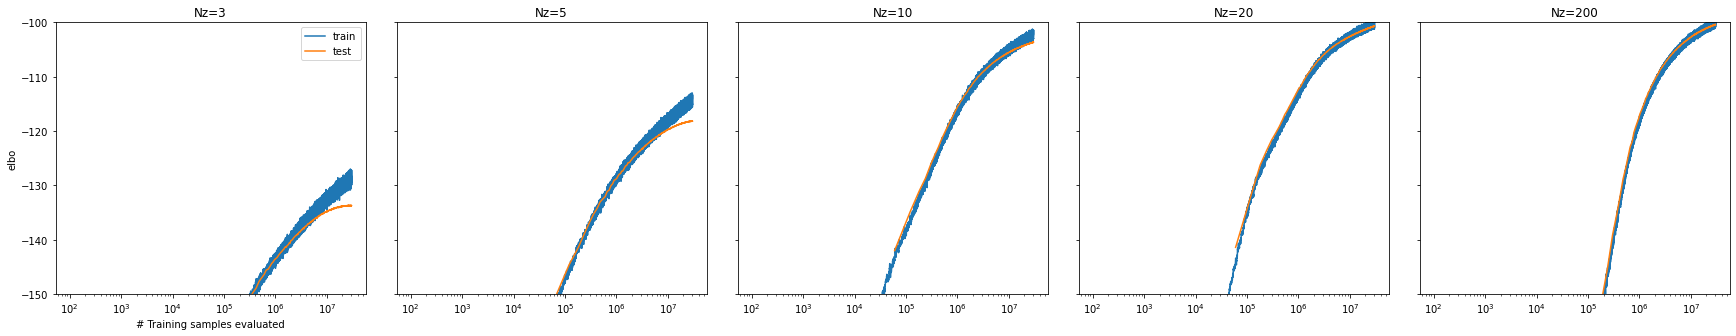

In [7]:
fig, ax = plt.subplots(ncols=5, figsize=(30, 5), sharey=True, gridspec_kw={'wspace':0.1})

for i, dim_latent in enumerate(stats):
    train_elbo_cruve, test_elbo_cruve = stats[dim_latent]
    
    ax[i].plot(train_elbo_cruve.index, train_elbo_cruve.values, label='train')
    ax[i].plot(test_elbo_cruve.index, test_elbo_cruve.values, label='test')
    ax[i].set_ylim(-150, -100)
    ax[i].set_xscale('log')
    ax[i].set_title(f"Nz={dim_latent}")

ax[0].set_xlabel('# Training samples evaluated')
ax[0].set_ylabel('elbo')
ax[0].legend()

# Learned MNIST Manifold
We restrict the size of latent space to 2, vary generated the value of in both two directions to produce a series of linearly spaced 2d latent variables. Then we plot the images generated by the given 2d latent variables.

In [10]:
basic_params = {
    'model.dim_latent': 2,
    'model.dim_input': 28 * 28,
    'model.dim_hidden': 500,
    'learning.batch_size': 100,
    'learning.lr': 0.02,
    'learning.num_epoch': 100,
}
config = Config(**basic_params)
model, *_ = vae.exp(config, return_model=True)

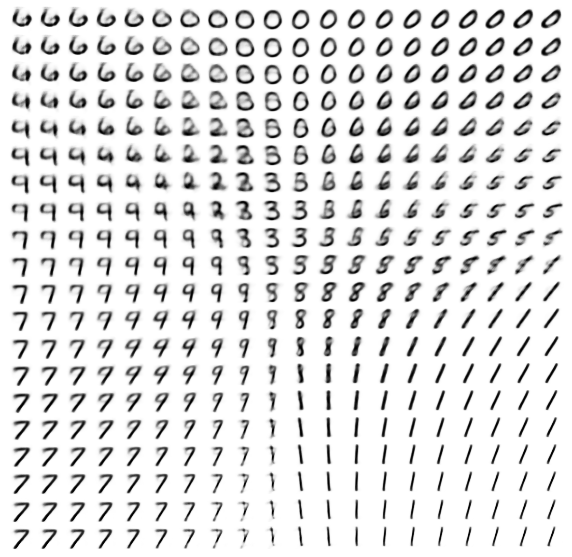

In [12]:
num_row, num_col = 20, 20

# draw samples from encoder 
xs, ys = np.meshgrid(np.linspace(-3, 3, num_row), np.linspace(-3, 3, num_col))
z = np.stack([xs.flatten(), ys.flatten()], axis=1)
z = torch.tensor(z, dtype=torch.float)
if torch.cuda.is_available():
    z = z.cuda()
draw_samples = model.decoder.prob(z)
imgs = draw_samples.cpu().data.numpy().reshape(-1, 28, 28)

# show the samples
f, ax = plt.subplots(num_row, num_col, 
                     figsize=(10, 10),
                     gridspec_kw={'wspace':0, 'hspace':0}, 
                     squeeze=True)

for i in range(num_row):
    for j in range(num_col):
        im = imgs[num_row * i + j]
        ax[i, j].imshow(im, cmap='Greys', aspect='auto')
        ax[i, j].axis('off')